In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**<font color = red> Preprocessing & Text-to-vector Transformation </font>**

In [40]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
import matplotlib.pyplot as plt

# NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [41]:
def preprocess_text(data):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    processed_data = []
    for k in data:
        review = re.sub('[^a-zA-Z]', ' ', k).lower().split()
        stem_list = [lemmatizer.lemmatize(i) for i in review if i not in stop_words]
        processed_data.append(' '.join(stem_list))
    return processed_data


In [42]:
# Load the datasets
x_train = pd.read_csv('/content/drive/MyDrive/Final Project/X_train.csv', delimiter=',', encoding='latin1')
x_test = pd.read_csv('/content/drive/MyDrive/Final Project/X_test.csv', delimiter=',', encoding='latin1')
Y_train = pd.read_csv('/content/drive/MyDrive/Final Project/y_train.csv')
Y_train = Y_train.values.ravel()



In [43]:
import nltk
nltk.download('punkt')
# Apply preprocessing
X_clean = preprocess_text(x_train['review'])
X_clean_test = preprocess_text(x_test['review'])



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
import nltk
from nltk.corpus import stopwords

# Ensure the stopwords are downloaded
nltk.download('stopwords')

# Retrieve the list of English stopwords once, outside the loop
stop_words = set(stopwords.words('english'))

split_data = []
# Loop over each review, split into words, and filter out stopwords
for rev in x_train['review']:
    words = rev.split()
    split_data.extend([word for word in words if word.lower() not in stop_words])

# Join the words back into a single string of text
full_text = " ".join(split_data)

# Print the length of the full text string
print(len(full_text))


151312


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Initialize the CountVectorizer
count_vect = CountVectorizer()

# Convert the training data text to a matrix of token counts
x_train_counts = count_vect.fit_transform(X_clean)

# Initialize the TfidfTransformer
tfidf_transformer = TfidfTransformer()

# Transform the count matrix to a normalized tf or tf-idf representation
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

# Transform the test data text to the same matrix of token counts
x_test_counts = count_vect.transform(X_clean_test)

# Transform the count matrix to a normalized tf or tf-idf representation
x_test_tfidf = tfidf_transformer.transform(x_test_counts)



In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer to the training data and transform it into a TF-IDF matrix
x_train_tfidf = tfidf_vectorizer.fit_transform(X_clean)

# Transform the test data into a TF-IDF matrix using the same vectorizer
x_test_tfidf = tfidf_vectorizer.transform(X_clean_test)

# Print the shapes of the transformed data to verify dimensions
print(f"Training Data Shape: {x_train_tfidf.shape}")
print(f"Test Data Shape: {x_test_tfidf.shape}")


Training Data Shape: (620, 870)
Test Data Shape: (267, 870)


In [47]:
# Vectorization
tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(X_clean)
x_test_tfidf = tfidf_vectorizer.transform(X_clean_test)

#**<font color = red> Model Building & Feature Selection </font>**

In [48]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(x_train_tfidf, Y_train, test_size=0.2, random_state=42)


In [49]:
print(X_train.shape)
print(y_train.shape)

(496, 870)
(496,)


In [50]:
# Feature selection
sel_var = VarianceThreshold()
X_train_filtered = sel_var.fit_transform(X_train)
X_val_filtered = sel_var.transform(X_val)

train_scores = []
validation_scores = []
train_f1_scores = []
validation_f1_scores = []

for num_features in range(1, X_train_filtered.shape[1] + 1, 10):
    selector = SelectKBest(score_func=f_classif, k=num_features)
    X_train_selected = selector.fit_transform(X_train_filtered, y_train).toarray()
    X_val_selected = selector.transform(X_val_filtered).toarray()
    clf = GaussianNB()
    clf.fit(X_train_selected, y_train)
    train_score = clf.score(X_train_selected, y_train)
    val_score = clf.score(X_val_selected, y_val)
    y_train_pred = clf.predict(X_train_selected)
    y_val_pred = clf.predict(X_val_selected)
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    train_scores.append(train_score)
    validation_scores.append(val_score)
    train_f1_scores.append(train_f1)
    validation_f1_scores.append(val_f1)



In [51]:
# Analysis DataFrame
num_features_range = list(range(1, X_train_filtered.shape[1] + 1, 10))
data = {
    'Number of Attributes': num_features_range,
    'Training Score (%)': [s * 100 for s in train_scores],
    'Validation Score (%)': [s * 100 for s in validation_scores],
    'Training F1 Score (%)': [s * 100 for s in train_f1_scores],
    'Validation F1 Score (%)': [s * 100 for s in validation_f1_scores]
}
df = pd.DataFrame(data)
df['Absolute Difference in Scores (%)'] = np.abs(df['Training Score (%)'] - df['Validation Score (%)'])
print(df.head(20))


    Number of Attributes  Training Score (%)  Validation Score (%)  \
0                      1           76.612903             77.419355   
1                     11           89.112903             83.064516   
2                     21           90.927419             85.483871   
3                     31           90.725806             87.903226   
4                     41           92.741935             88.709677   
5                     51           91.733871             90.322581   
6                     61           91.532258             88.709677   
7                     71           83.669355             83.870968   
8                     81           80.645161             75.806452   
9                     91           80.443548             74.193548   
10                   101           85.080645             79.838710   
11                   111           84.677419             79.032258   
12                   121           81.451613             72.580645   
13                  

In [52]:
# Overfitting Check
max_val_score_index = np.argmax(validation_scores)
optimal_num_features = num_features_range[max_val_score_index]
threshold = 5  # 5 percent
if (train_scores[max_val_score_index] - validation_scores[max_val_score_index]) <= threshold:
    print("Optimal number of attributes:", optimal_num_features)
else:
    print("Potential overfitting detected. Re-evaluating the optimal number of attributes.")


Optimal number of attributes: 161


In [53]:
# Check for overfitting by comparing the difference between train and validation F1-scores
# We can set a threshold for the maximum acceptable difference (e.g., 0.05 or 5%)


num_features_range = list(num_features_range)
validation_scores = np.array(validation_scores)
train_scores = np.array(train_scores)

max_val_score_index = np.argmax(validation_scores)
optimal_num_features = num_features_range[max_val_score_index]


threshold = 0.05
if (train_scores[max_val_score_index] - validation_scores[max_val_score_index]) <= threshold:
    print("Optimal number of attributes:", optimal_num_features)
else:
    print("Potential overfitting detected. Re-evaluating the optimal number of attributes.")

    # If overfitting is detected, choose the highest validation score with the least overfitting within the threshold
    acceptable_indices = np.where((train_scores - validation_scores) <= threshold)[0]
    if len(acceptable_indices) > 0:
        optimal_index = acceptable_indices[np.argmax(validation_scores[acceptable_indices])]
        optimal_num_features = num_features_range[optimal_index]
        print("Adjusted optimal number of attributes:", optimal_num_features)
    else:
        print("No attribute count met the overfitting threshold. Consider revising the model or threshold.")


Optimal number of attributes: 161


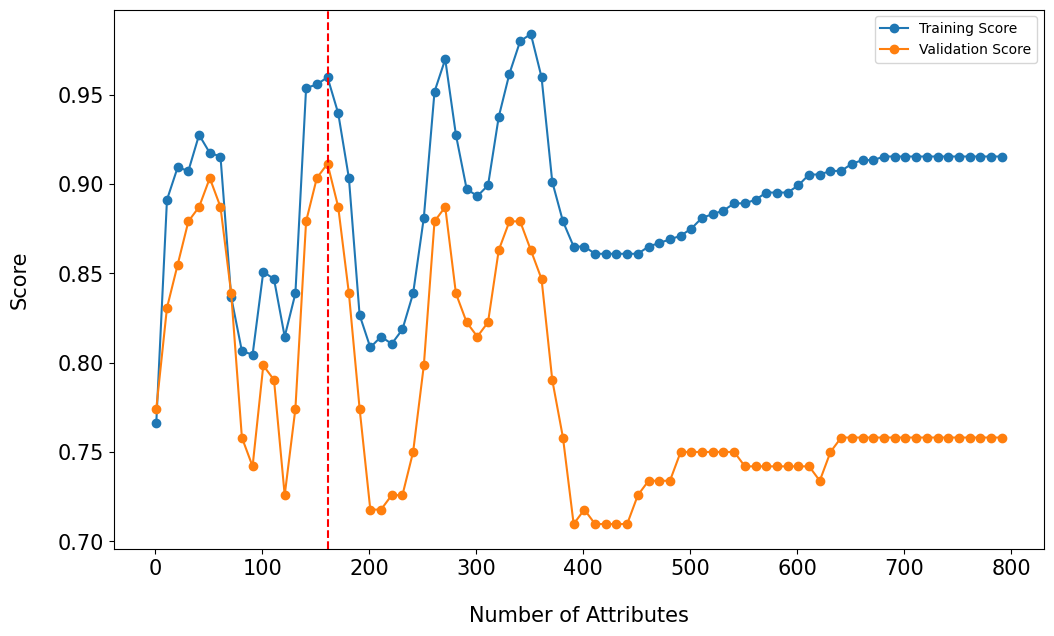

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))
plt.plot(num_features_range, train_scores, label='Training Score', marker='o')
plt.plot(num_features_range, validation_scores, label='Validation Score', marker='o')
plt.xlabel('Number of Attributes', labelpad=20, fontsize=15)
plt.ylabel('Score', labelpad=20, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axvline(x=optimal_num_features, color='r', linestyle='--')
plt.legend()
plt.show()


In [55]:
optimal_num_features

161

In [56]:
# Final Model Training
final_selector = SelectKBest(score_func=f_classif, k=optimal_num_features)
# Convert sparse matrix to dense, as SelectKBest and GaussianNB expect dense inputs
x_train_final = final_selector.fit_transform(x_train_tfidf.toarray(), Y_train)
final_model = GaussianNB()
final_model.fit(x_train_final, Y_train)

# Predictions
X_test_selected = final_selector.transform(x_test_tfidf.toarray())
y_pred_test = final_model.predict(X_test_selected)

# Result DataFrame
result_y_test = pd.DataFrame(y_pred_test, columns=['class'])
print(result_y_test.head())


   class
0      1
1      1
2      1
3      1
4      1


In [57]:
# Save the prediction as a .csv file

result_y_test.to_csv('/content/drive/MyDrive/result.csv', index=False) # you can set your own directory and file name

In [58]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif


# Vectorize the text data
tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(X_clean)
X_test_tfidf = tfidf_vect.transform(X_clean_test)

# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, Y_train, test_size=0.2, random_state=42)

# Feature Selection
selector = SelectKBest(score_func=f_classif, k=15)
X_train_selected = selector.fit_transform(X_train, y_train)
X_val_selected = selector.transform(X_val)

# Confirming shapes after transformations
print("Shapes after transformations and feature selection:")
print("X_train_selected:", X_train_selected.shape)
print("y_train:", y_train.shape)

# Retrieve selected feature names and f-values
feature_names = tfidf_vect.get_feature_names_out()
selected_indices = selector.get_support(indices=True)
selected_features = [feature_names[i] for i in selected_indices]
f_values_selected = selector.scores_[selected_indices]


Shapes after transformations and feature selection:
X_train_selected: (496, 15)
y_train: (496,)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


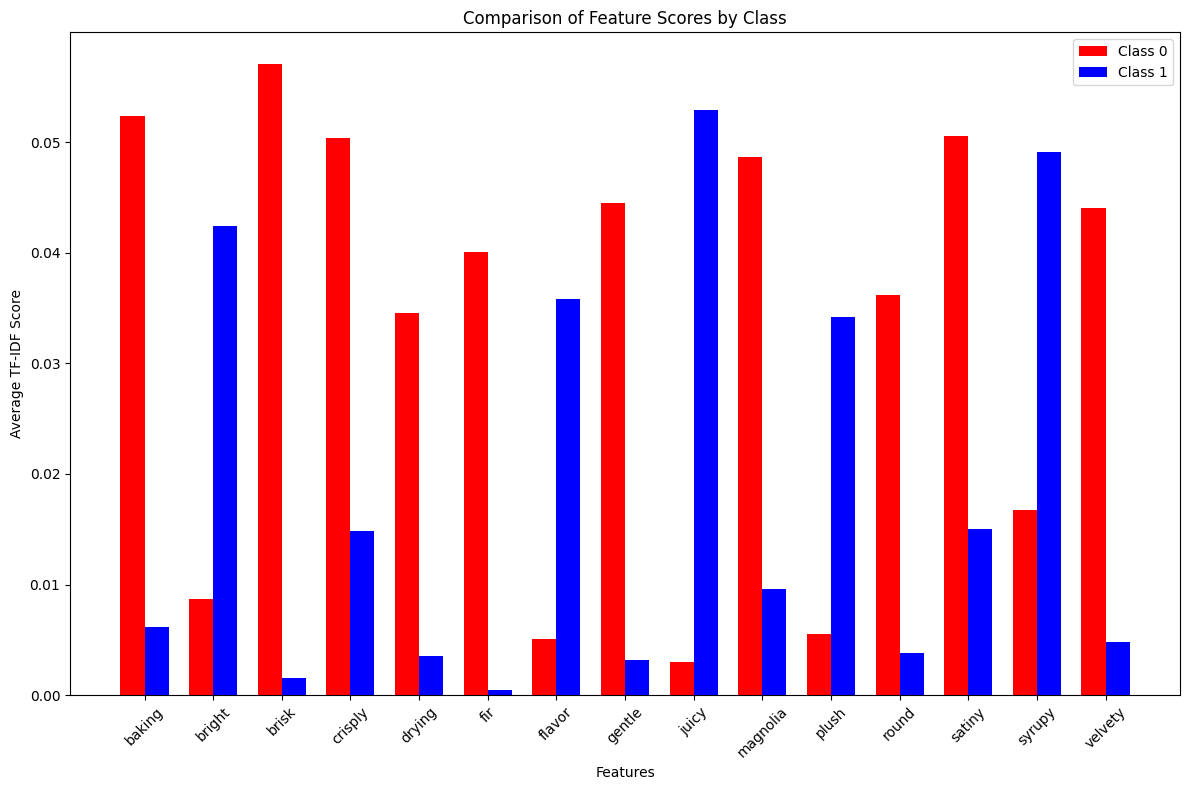

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(x_train['review'])

# Convert labels to an array if necessary
y = Y_train.values.ravel() if hasattr(Y_train, 'values') else np.array(Y_train)

# Select the top 10 most informative features
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X_tfidf, y)
selected_features = np.array(vectorizer.get_feature_names_out())[selector.get_support()]

# Calculate the mean TF-IDF score for each feature per class
mean_tfidf_class0 = X_selected[y == 0].mean(axis=0).A.flatten()
mean_tfidf_class1 = X_selected[y == 1].mean(axis=0).A.flatten()

# Create a plot to compare the average TF-IDF scores
fig, ax = plt.subplots(figsize=(12, 8))
indices = np.arange(len(selected_features))
width = 0.35

ax.bar(indices - width/2, mean_tfidf_class0, width, label='Class 0', color='red')
ax.bar(indices + width/2, mean_tfidf_class1, width, label='Class 1', color='blue')
ax.set_xticks(indices)
ax.set_xticklabels(selected_features, rotation=45)
ax.set_xlabel('Features')
ax.set_ylabel('Average TF-IDF Score')
ax.set_title('Comparison of Feature Scores by Class')
ax.legend()

plt.tight_layout()
plt.show()


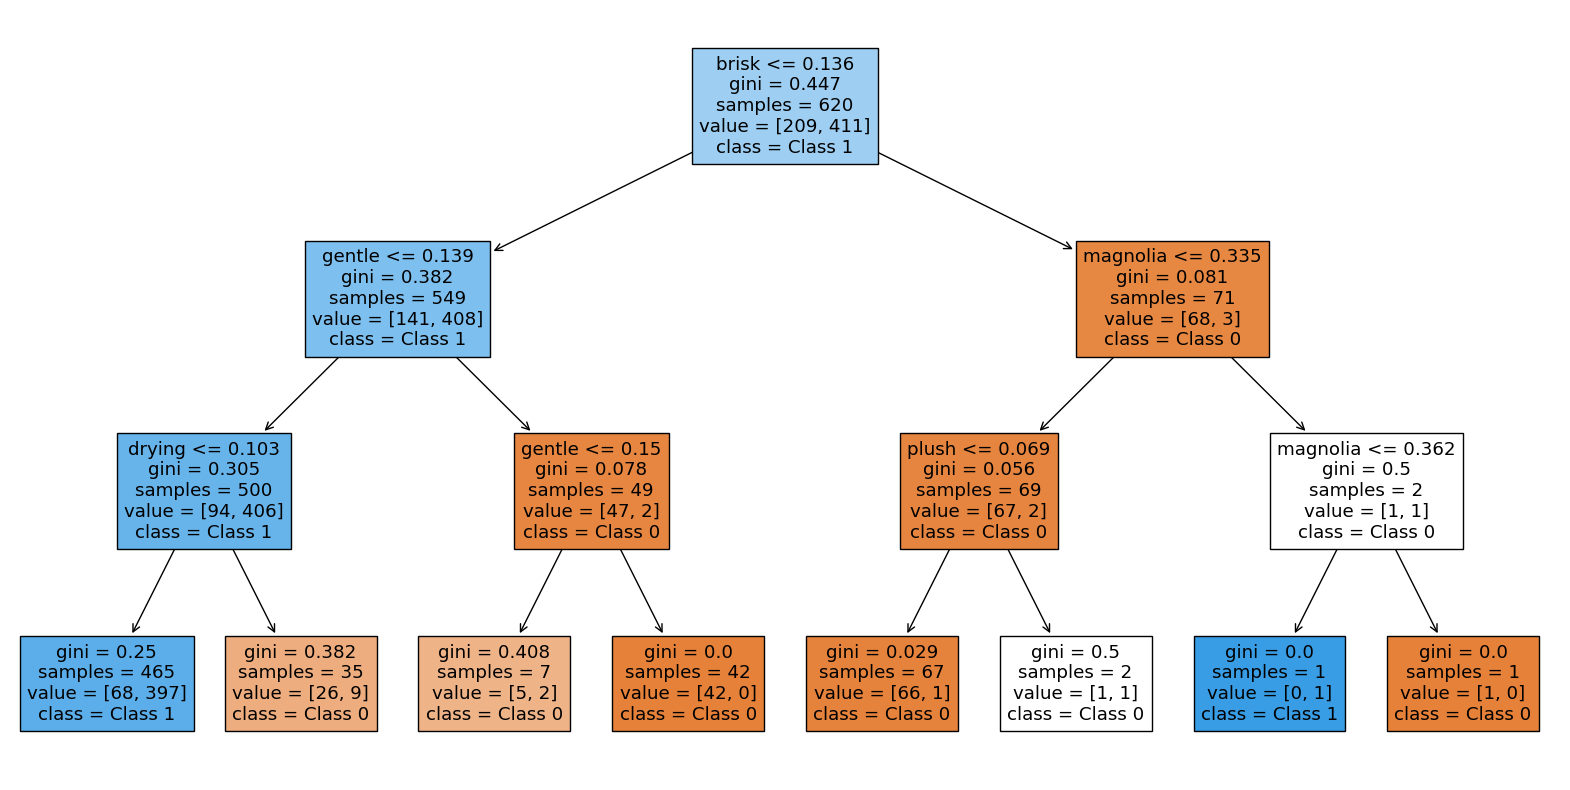

In [60]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

X_dense = X_selected.toarray()

# Training a decision tree on the selected features
tree_model = DecisionTreeClassifier(max_depth=3)
tree_model.fit(X_dense, y)

# Visualizing the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_model, filled=True, feature_names=selected_features, class_names=['Class 0', 'Class 1'])
plt.show()
